In [2]:
!pip install neptune-client>=0.11.0 pytorch-lightning==1.6.4 scikit-plot==0.3.7 torchvision>=0.6
!pip install kornia
!git clone https://github.com/RetamalVictor/CBIM-Medical-Image-Segmentation.git && pip install SimpleITK==2.0.0 --quiet
!cd /content/CBIM-Medical-Image-Segmentation && pip install -r requirement.txt --quiet
%cd /content/CBIM-Medical-Image-Segmentation/
# import cv2
# import os
# import glob
# import yaml
# import argparse
# import SimpleITK as sitk
# from pprint import pprint
# import matplotlib.pyplot as plt
# import torch
# import torch.nn as nn
# from torch import tensor
# from torch import optim
# import torch.nn.functional as F
# from torch.utils.data import Dataset
# from torch.utils.data import DataLoader
# from model.dim2.unet import *
# from model.dim2.utnetv2 import *
# from training.dataset.dim2.dataset_camus import CAMUSDataset
# import kornia as K
# import pytorch_lightning as pl
# import torchvision
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import random_split, DataLoader
# from pytorch_lightning import LightningModule, Trainer
# from pytorch_lightning.callbacks import ModelCheckpoint
from google.colab import drive

# from torchvision.utils import make_grid
# from pytorch_lightning.callbacks import EarlyStopping
# from pytorch_lightning import loggers as pl_loggers
# import numpy as np
# import os
# import torch
# import numpy as np
# from torch.utils.data import Dataset
# import SimpleITK as sitk
# import yaml
# import random
# from tqdm import tqdm
# from neptune.new.types import File
# from training import augmentation
# from training import losses
# from pytorch_lightning.loggers import NeptuneLogger
import matplotlib.pyplot as plt
import SimpleITK as sitk
import yaml
from imutils import contours
import numpy as np
import imutils
import cv2
import numpy as np
import torch

drive.mount("/content/drive")

# these remain constant
filepath = "/content/drive/MyDrive/AI4MED/training/training/"
filepath_checkpoint = "/content/drive/MyDrive/AI4MED/model-checkpoints/"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'CBIM-Medical-Image-Segmentation' already exists and is not an empty directory.
/content/CBIM-Medical-Image-Segmentation
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def distance(a, b):
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)


def is_between(a, c, b):
    return distance(a, c) + distance(c, b) == distance(a, b)


def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)


def get_widths(mask_2chamber, mask_4chamber, disk_size=25, mode="ED"):
    """
    Function that takes as input the segmentation mask of the 2chamber and 4chmber view
    splits the vetricle into small disks and calculates the width of the ventricle at
    each slice. It returns a list of the ventricle widths for each mask and the length of the ventricle
    ----------------
    input:
    mask_2chamber: segmentation mask of the 2chamber view
    mask_4chamber: segmentation mask of the 4chamber view
    disk_size: size of the disk used to split the ventricle into small disks
    returns:
    ventricle_widths: list of two lists containing the ventricle widths for each mask size
    ventricle_length: length of the ventricle
    """

    ventricle_widths = []
    for k, image in enumerate([mask_2chamber, mask_4chamber]):
        ventricle_segment = np.array((image == 1), dtype=np.uint8)

        # Normalise image
        normed_img = (ventricle_segment - ventricle_segment.min()) / (
            ventricle_segment.max() - ventricle_segment.min()
        )
        normed_img = (ventricle_segment * 255).astype(np.uint8)
        # Make a figure with 2 subplots showing image and normalised image

        # Find the edges in the image using canny detector
        edged = cv2.Canny(normed_img, 50, 200)

        # find contours in the edge map
        cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        cnts = imutils.grab_contours(cnts)

        # sort the contours from left-to-right and initialize the
        # 'pixels per metric' calibration variable
        (cnts, _) = contours.sort_contours(cnts)

        # From the contours, find the contour with the largest area
        # and keep only the contour with the largest area
        cnts = [max(cnts, key=cv2.contourArea)]

        # loop over the contours individually
        for c in cnts:
            # if the contour is not sufficiently large, ignore it
            # if cv2.contourArea(c) < 2:
            #     plt.figure()
            #     plt.imshow(edged)
            #     plt.title(c.shape)
            #     plt.show()
            #     print('here')
            #     continue
            # compute the rotated bounding box of the contour
            orig = image.copy()
            hull = cv2.convexHull(c).squeeze(1)

            # Find the highest point (lowest y value) in the hull
            highest_idx = np.argmin(hull[:, 1])
            highest_point = hull[highest_idx]

            lines = cv2.HoughLinesP(
                edged,
                rho=1,
                theta=1 * np.pi / 180,
                threshold=50,
                minLineLength=15,
                maxLineGap=80,
            )
            angles = []
            lines_of_interest = []
            if lines is not None:
                N = lines.shape[0]
                for i in range(N):
                    x1 = lines[i][0][0]
                    y1 = lines[i][0][1]
                    x2 = lines[i][0][2]
                    y2 = lines[i][0][3]
                    middle_x = int(np.floor(x1 + 0.5 * (x2 - x1)))
                    middle_y = int(np.floor(y1 + 0.5 * (y2 - y1)))
                    kernel = np.array([[-2, -1, 0, 1, 2]])
                    window_x = middle_x + kernel
                    window_v = middle_y + kernel
                    values = set()
                    for x in range(-10, 11):
                        for y in range(-10, 11):
                            # Check that the window is within the image
                            if (
                                (middle_y + y) < 0 or (middle_y + y) >= image.shape[0]
                            ) or (
                                (middle_x + x) < 0 or (middle_x + x) >= image.shape[1]
                            ):
                                continue
                            else:
                                values.add(image[middle_y + y, middle_x + x])
                    if values.issubset([1, 3]):
                        # Draw the line on the image
                        cv2.line(
                            orig,
                            [int(highest_point[0]), int(highest_point[1])],
                            [middle_x, middle_y],
                            (255, 0, 0),
                            1,
                        )
                        # Append the line to the list of lines of interest
                        lines_of_interest.append([(x1, y1), (x2, y2)])
                        # Save the point middle point
                        mid_bottom = (middle_x, middle_y)

            # Separate the hull into smaller regions to compute th width of the ventricle
            min_y = np.min(hull[:, 1])
            max_y = np.max(hull[:, 1])
            # Start from the bottom of the hull and move up by 10 pixels
            # until the top of the hull is reached
            # For each region, compute the width of the ventricle
            # and add it to the list
            y_bottom = max_y
            # Calculate the length of the ventricle
            if len(lines_of_interest) == 0:
                # Get the bottom right point of the contour
                # Find the point with the highest x value and highest y value
                bottom_right_idx = np.argmax(hull[:, 0] + hull[:, 1])
                bottom_right = hull[bottom_right_idx]
                # Get the bottom left point of the contour
                # Find the point with the lowest x value and highest y value
                bottom_left_idx = np.argmin(hull[:, 0] - hull[:, 1])
                bottom_left = hull[bottom_left_idx]
                # Find which point of the contour is closest to the middle of the bottom left and right points
                mid_bottom = np.array((bottom_left + bottom_right) / 2)

            if k == 1:
                ventricle_length = np.sqrt(
                    (highest_point[0] - mid_bottom[0]) ** 2
                    + (highest_point[1] - mid_bottom[1]) ** 2
                )

            current_ventricle_widths = []
            conts = c.squeeze(1)

            for y in range(y_bottom - disk_size, min_y, -disk_size):
                # Print y and y_bottom
                # print(f'y: {y}, y_bottom: {y_bottom}')
                # Find the points in the hull that are at the current y value
                # and find the middle point to compute the width
                hull_y = conts[conts[:, 1] <= y_bottom]
                hull_y = hull_y[hull_y[:, 1] >= y]
                # Check if there are any points in the hull at the current y value
                if len(hull_y) > 0:
                    # Find the pointthat is closest to the middle between the top and bottom
                    # of the current region (y and y_bottom) and compute the width from the
                    # left and right side of the ventricle
                    middle_y = int(np.floor(y + 0.5 * (y_bottom - y)))
                    middle_x = int(np.floor(np.mean(hull_y[:, 0])))

                    # Find which two points (left and right) of the hull are closest ventricle_widthsto
                    # the middle point and compute the width from the
                    # left and right side of the ventricle
                    left_point = hull_y[
                        np.argmin(
                            np.cross(hull_y - middle_x, hull_y - middle_y)
                            / np.linalg.norm(hull_y - middle_x)
                        )
                    ]
                    right_point = hull_y[
                        np.argmax(
                            np.cross(hull_y - middle_x, hull_y - middle_y)
                            / np.linalg.norm(hull_y - middle_x)
                        )
                    ]
                    # cv2.line(orig,[int(left_point[0]), left_point[1]],[right_point[0], right_point[1]],
                    #       (255, 0, 0),
                    #       1,
                    #   )
                    # Width of the ventricle is the distance between the left and right point
                    width = np.sqrt(
                        (left_point[0] - right_point[0]) ** 2
                        + (left_point[1] - right_point[1]) ** 2
                    )
                    # Add the width to the list
                    current_ventricle_widths.append(width)

                    # Update the left and right points
                    current_left = left_point
                    current_right = right_point
                else:
                    # Print hull_y and the current y value
                    print(f"hull_y: {hull_y}, y: {y}, y_bottom: {y_bottom}")
                    # If there are no points in the hull at the current y value
                    # then the width of the ventricle is the same as the previous
                    # ventricle_widths[k].append(ventricle_widths[k][-1])
                    # Move the bottom of the region up by 10 pixels
                    current_left[1] -= disk_size
                    current_right[1] -= disk_size

                    # cv2.line(orig, (int(current_left[0]), int(current_left[1])),(int(current_right[0]), int(current_right[1])),(255,0,0),5)

                # Update the bottom y valuebottom of the regionbottom ofbottom of the region the region
                y_bottom = y
                # plt.figure()
                # plt.imshow(orig)

        # Add the list of ventricle widths to the list of ventricle widths
        ventricle_widths.append(current_ventricle_widths)

    return ventricle_widths, ventricle_length


# Method tha takes as input the dimensions (width and length) of the ventricle
# on systole and siastole for each chamber view and computes the volume of the ventricle
def compute_volume(ventricle_widths, ventricle_length):
    """
    Takes as input the dimensions (width and length) of the ventricle
    on systole and siastole for each chamber view and computes the volume of the ventricle
    ---------
    input
    ventricle_widths: list of lists of floats
        List of lists of floats containing the width of the ventricle at each point in the ventricle
        for each chamber view
    ventricle_length: float
        Length of the ventricle
    ---------
    output
    ventricle_volume: float
        Volume of the ventricle
    """
    # Make the lists the same length
    # Find the minimum length of the diastole and systole lists
    max_length = max([len(ventricle_widths[x]) for x in range(len(ventricle_widths))])
    assert len(ventricle_widths) == 2 and max_length > 0
    # Make the lists the same length
    for i in range(2):
        if len(ventricle_widths[i]) < max_length:
            # Copy the first value of the list in the beginning of the list
            # until the list is the same length as the other lists
            while len(ventricle_widths[i]) < max_length:
                ventricle_widths[i].insert(0, ventricle_widths[i][0])
    width_array = np.array(ventricle_widths[:2])
    volume = np.sum(np.pi * width_array[0] * width_array[1] * ventricle_length)
    return volume


# Function that takes as input the ED and ES volumes of the ventricle and computes the EF
def compute_EF(ED_volume, ES_volume):
    return (ED_volume - ES_volume) / ED_volume * 100


# Create a function that takes as input the image mask of the 2chamber and 4chamber views
# 1. Calculates the EDV and ESV from the 2chamber and 4chambre view
# 2. Calculates the EF from the EDV and ESV
def calculate_volume(
    patient=10, filepath="/content/drive/MyDrive/AI4MED/", model_name="UTNetV2"
):
    # print('Initilised ventricle widths', ventricle_widths)
    for mode in ["ED", "ES"]:
        for ch in [2, 4]:
            if patient < 10:
                filename = (
                    f"{filepath}predictions/{model_name}/{model_name}_patient000{patient}__{ch}CH_{mode}_prediction"
                    # f"{filepath}predictions/{model_name}/{model_name}_patient000{patient}__{ch}CH_{mode}"
                )
            elif patient < 100:
                filename = (
                    f"{filepath}predictions/{model_name}/{model_name}_patient00{patient}__{ch}CH_{mode}_prediction"
                    # f"{filepath}predictions/{model_name}/{model_name}_patient00{patient}__{ch}CH_{mode}"
                )
            elif patient < 1000:
                filename = f"{filepath}predictions/{model_name}/{model_name}_patient0{patient}__{ch}CH_{mode}_prediction"
            # label = sitk.ReadImage(filename)
            # label_npa = sitk.GetArrayFromImage(label)
            # label_z = int(label.GetDepth() / 2)
            # label_npa_zslice = sitk.GetArrayViewFromImage(label)[label_z, :, :]
            # if label_npa_zslice is None:
            #     assert False, "No label found"
            if ch == 2:
                loaded_mask = torch.load(
                    filename, map_location=torch.device("cpu")
                ).squeeze(0)
                mask_2chamber = loaded_mask.detach().numpy()
            else:
                loaded_mask = torch.load(
                    filename, map_location=torch.device("cpu")
                ).squeeze(0)
                mask_4chamber = loaded_mask.detach().numpy()
        if mode == "ED":
            ventricle_ED_widths, ventricle_length = get_widths(
                mask_2chamber, mask_4chamber, disk_size=5, mode=mode
            )
        else:
            ventricle_ES_widths, _ = get_widths(
                mask_2chamber, mask_4chamber, disk_size=5, mode=mode
            )
    # Print the lengths of the lists
    # print(
    #     f"Length of ventricle ED widths: {len(ventricle_ED_widths)}, Length of ventricle ES widths: {len(ventricle_ES_widths)}"
    # )

    # Compute the ED and ES volumes
    volume_diastole = compute_volume(ventricle_ED_widths, ventricle_length)
    volume_systole = compute_volume(ventricle_ES_widths, ventricle_length)
    # Calculate the ejection fraction
    ejection_fraction = compute_EF(volume_diastole, volume_systole)

    # # print(f'Patient {patient},Volume diastole: {volume_diastole}, volume systole: {volume_systole}, ejection fraction: {ejection_fraction}')
    # if patient < 10:
    #     filename = f"{filepath}training/training/patient000{patient}/Info_{ch}CH.cfg"
    # elif patient < 100:
    #     filename = f"{filepath}training/training/patient00{patient}/Info_{ch}CH.cfg"
    # elif patient < 1000:
    #     filename = f"{filepath}training/training/patient0{patient}/Info_{ch}CH.cfg"
    # with open(filename) as info:
    #     # Read the contents of the .cfg file
    #     info = yaml.load(info, Loader=yaml.FullLoader)
    #     # Find the LVEF value
    #     true_ef = info["LVef"]
    # print(f"EDV:{volume_diastole},\tESV:{volume_systole}")
    # print(
    #     f"Patient {patient}, true EF: {true_ef:.3},estimated EF: {ejection_fraction:.3}, SE:{((true_ef - ejection_fraction)**2)}"
    # )

    # compute the error
    # error = abs(true_ef - ejection_fraction)
    return ejection_fraction


# errors = []
# for patient in range(1, 451):
#     error = calculate_volume(patient=patient)
#     errors.append(error)
# print("Mean error: ", np.mean(errors))

Load the predicted masks

In [4]:
def load_mask(patient, model_name):
    if patient < 10:
        patient_str = f"patient000{patient}"
    elif patient < 100:
        patient_str = f"patient00{patient}"
    elif patient < 1000:
        patient_str = f"patient0{patient}"

    # filename = (
    #     f"{filepath}predictions/{model_name}/{model_name}/{patient_str}__{ch}CH_{mode}_prediction"
    # )
    filepath = "/content/drive/MyDrive/AI4MED/"

    mask_2ch_ed = torch.load(
        f"{filepath}predictions/{model_name}/{model_name}_{patient_str}__2CH_ED_prediction",
        map_location=torch.device("cpu"),
    ).squeeze(0)
    mask_4ch_ed = torch.load(
        f"{filepath}predictions/{model_name}/{model_name}_{patient_str}__4CH_ED_prediction",
        map_location=torch.device("cpu"),
    ).squeeze(0)

    mask_2ch_es = torch.load(
        f"{filepath}predictions/{model_name}/{model_name}_{patient_str}__2CH_ES_prediction",
        map_location=torch.device("cpu"),
    ).squeeze(0)
    mask_4ch_es = torch.load(
        f"{filepath}predictions/{model_name}/{model_name}_{patient_str}__4CH_ES_prediction",
        map_location=torch.device("cpu"),
    ).squeeze(0)

    mask_2ch_gt_es = torch.load(
        f"{filepath}predictions/{model_name}/{patient_str}_2CH_ES_label",
        map_location=torch.device("cpu"),
    ).squeeze(0)
    mask_2ch_gt_ed = torch.load(
        f"{filepath}predictions/{model_name}/{patient_str}_2CH_ED_label",
        map_location=torch.device("cpu"),
    ).squeeze(0)
    mask_4ch_gt_es = torch.load(
        f"{filepath}predictions/{model_name}/{patient_str}_4CH_ES_label",
        map_location=torch.device("cpu"),
    ).squeeze(0)
    mask_4ch_gt_ed = torch.load(
        f"{filepath}predictions/{model_name}/{patient_str}_4CH_ED_label",
        map_location=torch.device("cpu"),
    ).squeeze(0)
    fig, ax = plt.subplots(2, 4)
    ax[0, 0].imshow(mask_2ch_ed)
    ax[0, 1].imshow(mask_2ch_gt_ed)
    ax[0, 2].imshow(mask_2ch_es)
    ax[0, 3].imshow(mask_2ch_gt_es)
    ax[1, 0].imshow(mask_4ch_ed)
    ax[1, 1].imshow(mask_4ch_gt_ed)
    ax[1, 2].imshow(mask_4ch_es)
    ax[1, 3].imshow(mask_4ch_gt_es)
    plt.title(f"{model_name}_patient000{patient}")

In [5]:
validation_patients = [4, 17, 24, 31, 44, 92, 96, 105, 111, 113]
model_names = ["UNET", "UTNetV2"]
results = {"UNET": [], "UTNetV2": []}
for patient in validation_patients:
    for m_name in model_names:
        results[m_name].append(calculate_volume(patient, model_name=m_name))

print(np.sqrt(np.mean(results["UNET"])), np.sqrt(np.mean(results["UTNetV2"])))

7.070306990463561 7.090542562878481


In [6]:
def load_mask_test(patient, model_name):
    if patient < 10:
        patient_str = f"patient000{patient}"
    elif patient < 100:
        patient_str = f"patient00{patient}"
    elif patient < 1000:
        patient_str = f"patient0{patient}"

    # filename = (
    #     f"{filepath}predictions/{model_name}/{model_name}/{patient_str}__{ch}CH_{mode}_prediction"
    # )
    filepath = "/content/drive/MyDrive/AI4MED/"

    mask_2ch_ed = torch.load(
        f"{filepath}predictions/camus_test/{patient_str}_2CH_ED",
        map_location=torch.device("cpu"),
    ).squeeze(0)
    mask_4ch_ed = torch.load(
        f"{filepath}predictions/camus_test/{patient_str}_4CH_ED",
        map_location=torch.device("cpu"),
    ).squeeze(0)

    mask_2ch_es = torch.load(
        f"{filepath}predictions/camus_test/{patient_str}_2CH_ES",
        map_location=torch.device("cpu"),
    ).squeeze(0)
    mask_4ch_es = torch.load(
        f"{filepath}predictions/camus_test/{patient_str}_4CH_ES",
        map_location=torch.device("cpu"),
    ).squeeze(0)

    # mask_2ch_gt_es = torch.load(f"{filepath}predictions/{model_name}/{patient_str}_2CH_ES_label", map_location=torch.device('cpu')).squeeze(0)
    # mask_2ch_gt_ed = torch.load(f"{filepath}predictions/{model_name}/{patient_str}_2CH_ED_label", map_location=torch.device('cpu')).squeeze(0)
    # mask_4ch_gt_es = torch.load(f"{filepath}predictions/{model_name}/{patient_str}_4CH_ES_label", map_location=torch.device('cpu')).squeeze(0)
    # mask_4ch_gt_ed = torch.load(f"{filepath}predictions/{model_name}/{patient_str}_4CH_ED_label", map_location=torch.device('cpu')).squeeze(0)
    fig, ax = plt.subplots(2, 2)
    ax[0, 0].imshow(mask_2ch_ed)
    # ax[0,1].imshow(mask_2ch_gt_ed)
    ax[0, 1].imshow(mask_2ch_es)
    # ax[0,3].imshow(mask_2ch_gt_es)
    ax[1, 0].imshow(mask_4ch_ed)
    # ax[1,1].imshow(mask_4ch_gt_ed)
    ax[1, 1].imshow(mask_4ch_es)
    # ax[1,3].imshow(mask_4ch_gt_es)
    plt.title(f"{model_name}_{patient_str}")

Plot the predicted masks of the test set

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


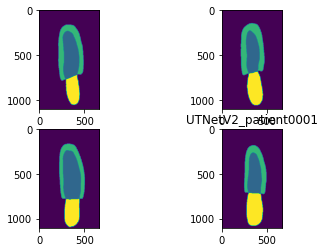

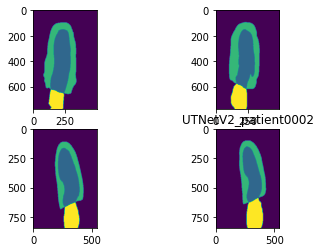

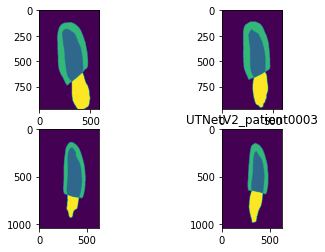

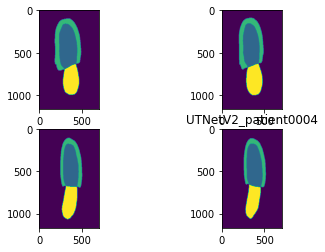

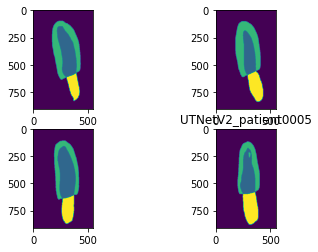

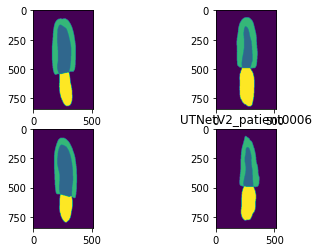

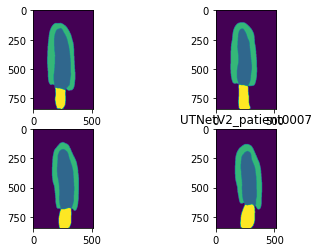

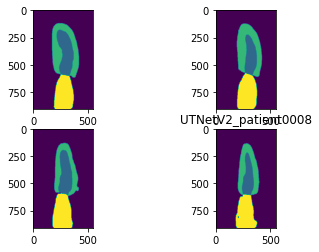

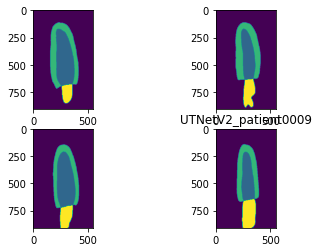

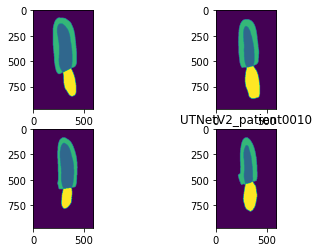

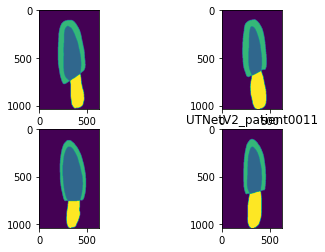

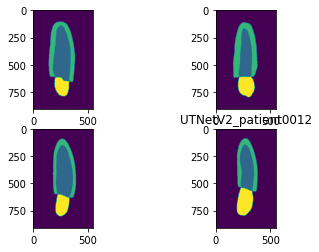

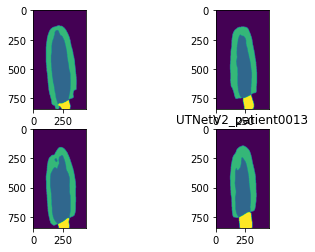

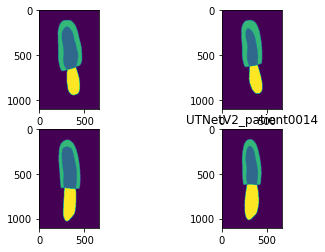

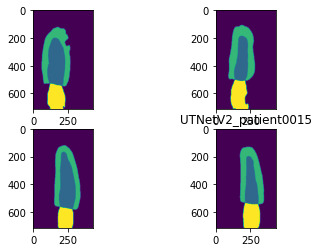

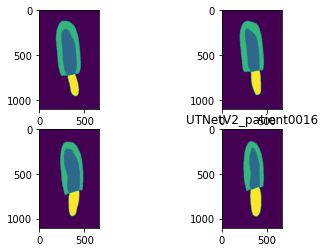

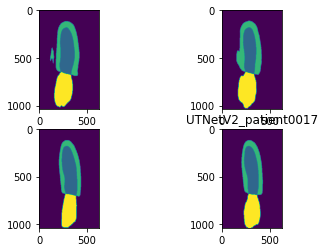

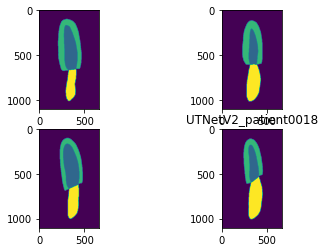

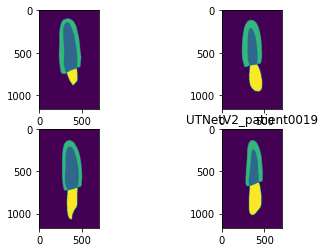

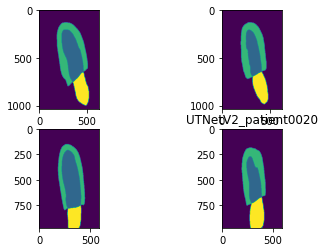

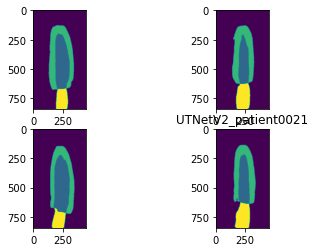

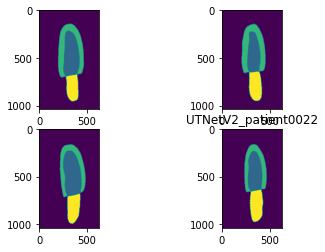

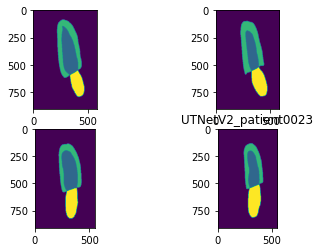

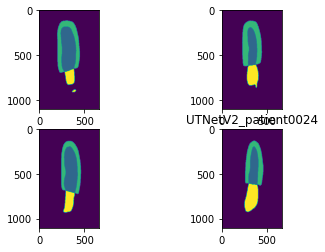

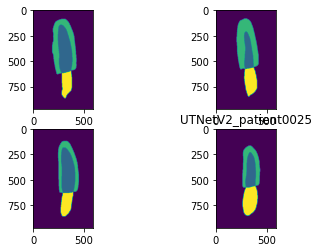

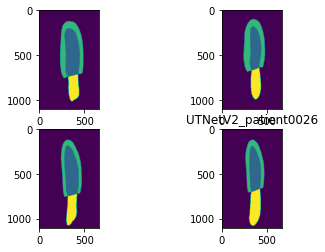

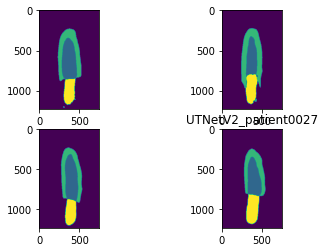

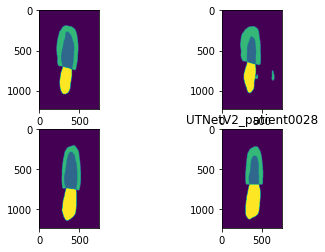

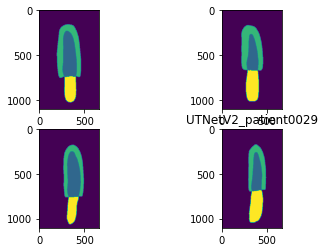

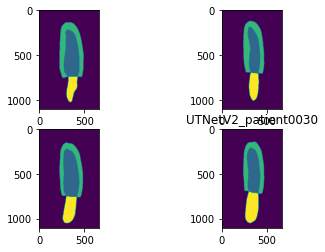

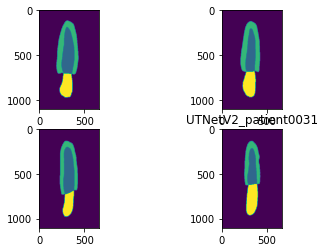

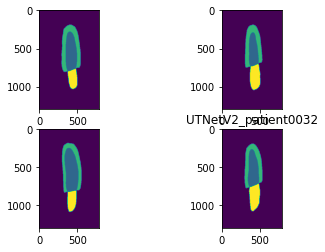

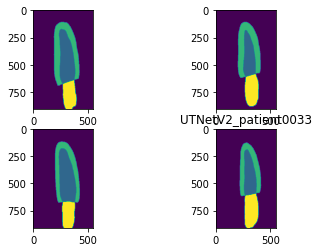

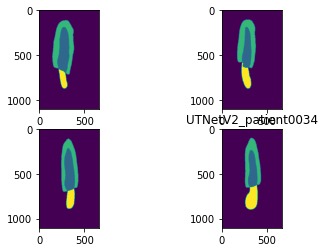

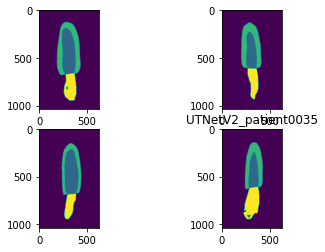

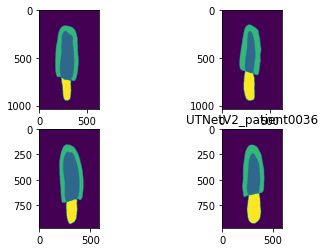

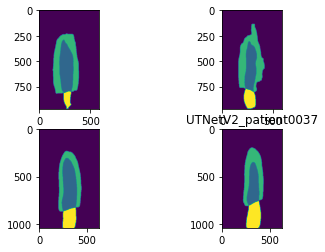

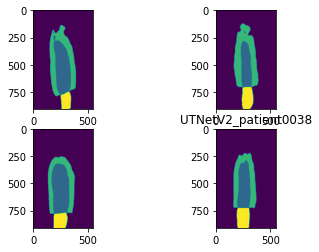

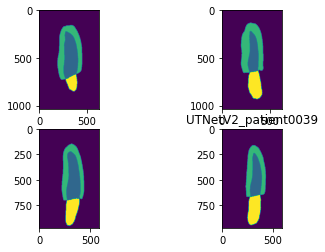

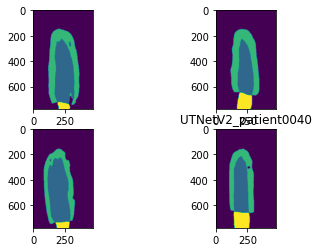

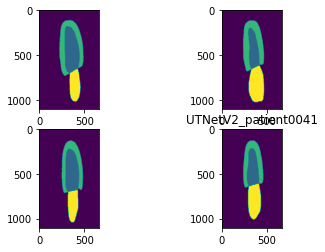

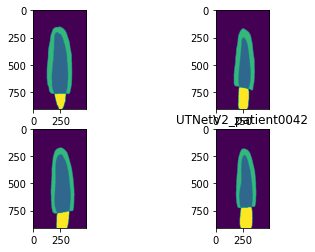

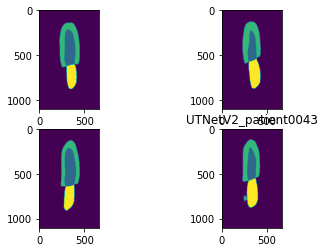

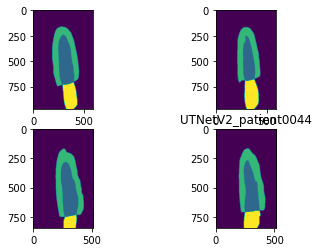

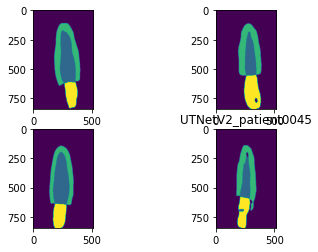

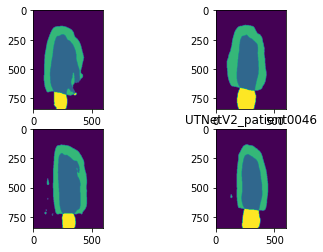

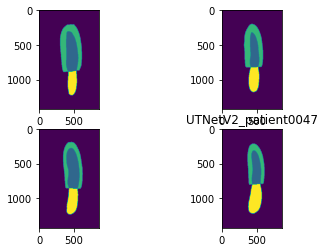

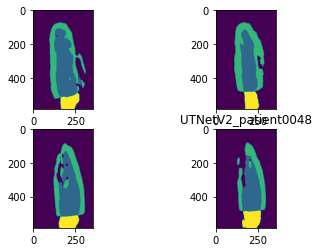

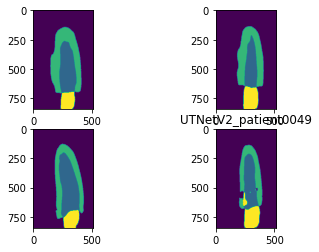

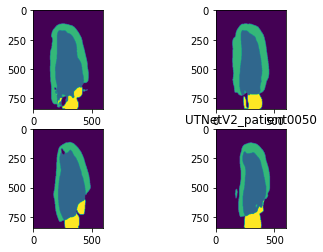

In [7]:
for patient in range(1, 51):
    load_mask_test(patient, "UTNetV2")

In [8]:
def distance(a, b):
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)


def is_between(a, c, b):
    return distance(a, c) + distance(c, b) == distance(a, b)


def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)


def get_widths(mask_2chamber, mask_4chamber, disk_size=25, mode="ED"):
    """
    Function that takes as input the segmentation mask of the 2chamber and 4chmber view
    splits the vetricle into small disks and calculates the width of the ventricle at
    each slice. It returns a list of the ventricle widths for each mask and the length of the ventricle
    ----------------
    input:
    mask_2chamber: segmentation mask of the 2chamber view
    mask_4chamber: segmentation mask of the 4chamber view
    disk_size: size of the disk used to split the ventricle into small disks
    returns:
    ventricle_widths: list of two lists containing the ventricle widths for each mask size
    ventricle_length: length of the ventricle
    """

    ventricle_widths = []
    for k, image in enumerate([mask_2chamber, mask_4chamber]):
        ventricle_segment = np.array((image == 1), dtype=np.uint8)

        # Normalise image
        normed_img = (ventricle_segment - ventricle_segment.min()) / (
            ventricle_segment.max() - ventricle_segment.min()
        )
        normed_img = (ventricle_segment * 255).astype(np.uint8)
        # Make a figure with 2 subplots showing image and normalised image

        # Find the edges in the image using canny detector
        edged = cv2.Canny(normed_img, 50, 200)

        # find contours in the edge map
        cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        cnts = imutils.grab_contours(cnts)

        # sort the contours from left-to-right and initialize the
        # 'pixels per metric' calibration variable
        (cnts, _) = contours.sort_contours(cnts)

        # From the contours, find the contour with the largest area
        # and keep only the contour with the largest area
        cnts = [max(cnts, key=cv2.contourArea)]

        # loop over the contours individually
        for c in cnts:
            # if the contour is not sufficiently large, ignore it
            if cv2.contourArea(c) < 2:
                # plt.figure()
                # plt.imshow(edged)
                # plt.title(c.shape)
                # plt.show()
                continue
            # compute the rotated bounding box of the contour
            orig = image.copy()
            hull = cv2.convexHull(c).squeeze(1)

            # Find the highest point (lowest y value) in the hull
            highest_idx = np.argmin(hull[:, 1])
            highest_point = hull[highest_idx]

            lines = cv2.HoughLinesP(
                edged,
                rho=1,
                theta=1 * np.pi / 180,
                threshold=50,
                minLineLength=15,
                maxLineGap=80,
            )
            angles = []
            lines_of_interest = []
            if lines is not None:
                N = lines.shape[0]
                for i in range(N):
                    x1 = lines[i][0][0]
                    y1 = lines[i][0][1]
                    x2 = lines[i][0][2]
                    y2 = lines[i][0][3]
                    middle_x = int(np.floor(x1 + 0.5 * (x2 - x1)))
                    middle_y = int(np.floor(y1 + 0.5 * (y2 - y1)))
                    kernel = np.array([[-2, -1, 0, 1, 2]])
                    window_x = middle_x + kernel
                    window_v = middle_y + kernel
                    values = set()
                    for x in range(-10, 11):
                        for y in range(-10, 11):
                            # Check that the window is within the image
                            if (
                                (middle_y + y) < 0 or (middle_y + y) >= image.shape[0]
                            ) or (
                                (middle_x + x) < 0 or (middle_x + x) >= image.shape[1]
                            ):
                                continue
                            else:
                                values.add(image[middle_y + y, middle_x + x])
                    if values.issubset([1, 3]):
                        # Draw the line on the image
                        cv2.line(
                            orig,
                            [int(highest_point[0]), int(highest_point[1])],
                            [middle_x, middle_y],
                            (255, 0, 0),
                            1,
                        )
                        # Append the line to the list of lines of interest
                        lines_of_interest.append([(x1, y1), (x2, y2)])
                        # Save the point middle point
                        mid_bottom = (middle_x, middle_y)

            # Separate the hull into smaller regions to compute th width of the ventricle
            min_y = np.min(hull[:, 1])
            max_y = np.max(hull[:, 1])
            # Start from the bottom of the hull and move up by 10 pixels
            # until the top of the hull is reached
            # For each region, compute the width of the ventricle
            # and add it to the list
            y_bottom = max_y
            # Calculate the length of the ventricle
            if len(lines_of_interest) == 0:
                # Get the bottom right point of the contour
                # Find the point with the highest x value and highest y value
                bottom_right_idx = np.argmax(hull[:, 0] + hull[:, 1])
                bottom_right = hull[bottom_right_idx]
                # Get the bottom left point of the contour
                # Find the point with the lowest x value and highest y value
                bottom_left_idx = np.argmin(hull[:, 0] - hull[:, 1])
                bottom_left = hull[bottom_left_idx]
                # Find which point of the contour is closest to the middle of the bottom left and right points
                mid_bottom = np.array((bottom_left + bottom_right) / 2)

            if k == 1:
                ventricle_length = np.sqrt(
                    (highest_point[0] - mid_bottom[0]) ** 2
                    + (highest_point[1] - mid_bottom[1]) ** 2
                )

            current_ventricle_widths = []
            conts = c.squeeze(1)

            for y in range(y_bottom - disk_size, min_y, -disk_size):
                # Print y and y_bottom
                # print(f'y: {y}, y_bottom: {y_bottom}')
                # Find the points in the hull that are at the current y value
                # and find the middle point to compute the width
                hull_y = conts[conts[:, 1] <= y_bottom]
                hull_y = hull_y[hull_y[:, 1] >= y]
                # Check if there are any points in the hull at the current y value
                if len(hull_y) > 0:
                    # Find the pointthat is closest to the middle between the top and bottom
                    # of the current region (y and y_bottom) and compute the width from the
                    # left and right side of the ventricle
                    middle_y = int(np.floor(y + 0.5 * (y_bottom - y)))
                    middle_x = int(np.floor(np.mean(hull_y[:, 0])))

                    # Find which two points (left and right) of the hull are closest ventricle_widthsto
                    # the middle point and compute the width from the
                    # left and right side of the ventricle
                    left_point = hull_y[
                        np.argmin(
                            np.cross(hull_y - middle_x, hull_y - middle_y)
                            / np.linalg.norm(hull_y - middle_x)
                        )
                    ]
                    right_point = hull_y[
                        np.argmax(
                            np.cross(hull_y - middle_x, hull_y - middle_y)
                            / np.linalg.norm(hull_y - middle_x)
                        )
                    ]
                    # Width of the ventricle is the distance between the left and right point
                    width = np.sqrt(
                        (left_point[0] - right_point[0]) ** 2
                        + (left_point[1] - right_point[1]) ** 2
                    )
                    # Add the width to the list
                    current_ventricle_widths.append(width)

                    # Update the left and right points
                    current_left = left_point
                    current_right = right_point
                else:
                    # Print hull_y and the current y value
                    print(f"hull_y: {hull_y}, y: {y}, y_bottom: {y_bottom}")
                    # If there are no points in the hull at the current y value
                    # then the width of the ventricle is the same as the previous
                    # ventricle_widths[k].append(ventricle_widths[k][-1])
                    # Move the bottom of the region up by 10 pixels
                    current_left[1] -= disk_size
                    current_right[1] -= disk_size

                    # cv2.line(orig, (int(current_left[0]), int(current_left[1])),(int(current_right[0]), int(current_right[1])),(255,0,0),5)

                # Update the bottom y valuebottom of the regionbottom ofbottom of the region the region
                y_bottom = y

        # Add the list of ventricle widths to the list of ventricle widths
        ventricle_widths.append(current_ventricle_widths)

    return ventricle_widths, ventricle_length


# Method tha takes as input the dimensions (width and length) of the ventricle
# on systole and siastole for each chamber view and computes the volume of the ventricle
def compute_volume(ventricle_widths, ventricle_length):
    """
    Takes as input the dimensions (width and length) of the ventricle
    on systole and siastole for each chamber view and computes the volume of the ventricle
    ---------
    input
    ventricle_widths: list of lists of floats
        List of lists of floats containing the width of the ventricle at each point in the ventricle
        for each chamber view
    ventricle_length: float
        Length of the ventricle
    ---------
    output
    ventricle_volume: float
        Volume of the ventricle
    """
    # Make the lists the same length
    # Find the minimum length of the diastole and systole lists
    max_length = max([len(ventricle_widths[x]) for x in range(len(ventricle_widths))])
    assert len(ventricle_widths) == 2 and max_length > 0
    # Make the lists the same length
    for i in range(2):
        if len(ventricle_widths[i]) < max_length:
            # Copy the first value of the list in the beginning of the list
            # until the list is the same length as the other lists
            while len(ventricle_widths[i]) < max_length:
                ventricle_widths[i].insert(0, ventricle_widths[i][0])
    width_array = np.array(ventricle_widths[:2])
    volume = np.sum(np.pi * width_array[0] * width_array[1] * ventricle_length)
    return volume


# Function that takes as input the ED and ES volumes of the ventricle and computes the EF
def compute_EF(ED_volume, ES_volume):
    return (ED_volume - ES_volume) / ED_volume * 100


# Create a function that takes as input the image mask of the 2chamber and 4chamber views
# 1. Calculates the EDV and ESV from the 2chamber and 4chambre view
# 2. Calculates the EF from the EDV and ESV
def calculate_volume(
    patient=10, filepath="/content/drive/MyDrive/AI4MED/", model_name="UTNetV2"
):
    # print('Initilised ventricle widths', ventricle_widths)
    for mode in ["ED", "ES"]:
        for ch in [2, 4]:
            if patient < 10:
                filename = f"{filepath}predictions/{model_name}/{model_name}_patient000{patient}__{ch}CH_{mode}_prediction"
            elif patient < 100:
                filename = f"{filepath}predictions/{model_name}/{model_name}_patient00{patient}__{ch}CH_{mode}_prediction"
            elif patient < 1000:
                filename = f"{filepath}predictions/{model_name}/{model_name}_patient0{patient}__{ch}CH_{mode}_prediction"
            # label = sitk.ReadImage(filename)
            # label_npa = sitk.GetArrayFromImage(label)
            # label_z = int(label.GetDepth() / 2)
            # label_npa_zslice = sitk.GetArrayViewFromImage(label)[label_z, :, :]
            # if label_npa_zslice is None:
            #     assert False, "No label found"
            if ch == 2:
                loaded_mask = torch.load(
                    filename, map_location=torch.device("cpu")
                ).squeeze(0)
                mask_2chamber = loaded_mask.detach().numpy()
            else:
                loaded_mask = torch.load(
                    filename, map_location=torch.device("cpu")
                ).squeeze(0)
                mask_4chamber = loaded_mask.detach().numpy()
        if mode == "ED":
            ventricle_ED_widths, ventricle_length = get_widths(
                mask_2chamber, mask_4chamber, disk_size=5, mode=mode
            )
        else:
            ventricle_ES_widths, _ = get_widths(
                mask_2chamber, mask_4chamber, disk_size=5, mode=mode
            )
    # Print the lengths of the lists
    print(
        f"Length of ventricle ED widths: {len(ventricle_ED_widths)}, Length of ventricle ES widths: {len(ventricle_ES_widths)}"
    )

    # Compute the ED and ES volumes
    volume_diastole = compute_volume(ventricle_ED_widths, ventricle_length)
    volume_systole = compute_volume(ventricle_ES_widths, ventricle_length)
    # Calculate the ejection fraction
    ejection_fraction = compute_EF(volume_diastole, volume_systole)

    # print(f'Patient {patient},Volume diastole: {volume_diastole}, volume systole: {volume_systole}, ejection fraction: {ejection_fraction}')
    if patient < 10:
        filename = f"{filepath}training/training/patient000{patient}/Info_{ch}CH.cfg"
    elif patient < 100:
        filename = f"{filepath}training/training/patient00{patient}/Info_{ch}CH.cfg"
    elif patient < 1000:
        filename = f"{filepath}training/training/patient0{patient}/Info_{ch}CH.cfg"
    with open(filename) as info:
        # Read the contents of the .cfg file
        info = yaml.load(info, Loader=yaml.FullLoader)
        # Find the LVEF value
        true_ef = info["LVef"]
    print(
        f"Patient {patient}, true EF: {true_ef:.3},estimated EF: {ejection_fraction:.3}, SE:{((true_ef - ejection_fraction)**2)}"
    )

    # compute the error
    error = abs(true_ef - ejection_fraction)
    return error


# errors = []
# for patient in range(1, 451):
#     error = calculate_volume(patient=patient)
#     errors.append(error)
# print("Mean error: ", np.mean(errors))

Computing the RMSE of the Enjection Fraction for the Validation patients

In [9]:
validation_patients = [4, 17, 24, 31, 44, 92, 96, 105, 111, 113]
model_names = ["UNET", "UTNetV2"]
results = {"UNET": [], "UTNetV2": []}
m_name = "UTNetV2"
for patient in validation_patients:
    for m_name in model_names:
        results[m_name].append(calculate_volume(patient, model_name=m_name))

print(
    f"\nRMSE\n\tUNET:{np.sqrt(np.mean(results['UNET'])):.3} \tUTNetV2:{np.sqrt(np.mean(results['UTNetV2'])):.3}"
)

Length of ventricle ED widths: 2, Length of ventricle ES widths: 2
Patient 4, true EF: 62.1,estimated EF: 63.4, SE:1.7323583721974716
Length of ventricle ED widths: 2, Length of ventricle ES widths: 2
Patient 4, true EF: 62.1,estimated EF: 62.2, SE:0.020703913596739742
Length of ventricle ED widths: 2, Length of ventricle ES widths: 2
Patient 17, true EF: 63.1,estimated EF: 53.6, SE:90.05027294416116
Length of ventricle ED widths: 2, Length of ventricle ES widths: 2
Patient 17, true EF: 63.1,estimated EF: 62.5, SE:0.394741126210995
Length of ventricle ED widths: 2, Length of ventricle ES widths: 2
Patient 24, true EF: 57.1,estimated EF: 65.2, SE:65.84241566629126
Length of ventricle ED widths: 2, Length of ventricle ES widths: 2
Patient 24, true EF: 57.1,estimated EF: 61.0, SE:15.048084286686436
Length of ventricle ED widths: 2, Length of ventricle ES widths: 2
Patient 31, true EF: 38.3,estimated EF: 42.8, SE:20.504020066883545
Length of ventricle ED widths: 2, Length of ventricle ES w